# Федеральное государственное автономное образовательное учреждение высшего образования
# «Национальный исследовательский университет «Высшая школа экономики»

**Московский институт электроники и математики им. А.Н. Тихонова**  
**Департамент электронной инженерии**  

*Направление подготовки 11.04.02 «Инфокоммуникационные технологии и системы связи»*  
*Образовательная программа «Интернет вещей и киберфизические системы»*

---

## Отчет по лабораторной работе №1
### Экстремальная робототехника
#### Тема: «Локализация мобильного робота с помощью фильтра Калмана»

---

<br>
<br>
<br>

**Выполнила:**  
Студент группы МИВ251  
Сатина Анастасия Павловна  

<br>
<br>

**Преподаватель:**  
Подгорный Леонид Евгеньевич  

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**Москва 2026 г.**

### Введение
#### Цель работы
Целью данной практической работы является освоение алгоритма фильтра Калмана для задачи локализации мобильной платформы в двумерном пространстве путём объединения (fusion) данных от различных датчиков с разной частотой обновления и разной точностью.

#### Задачи работы
1. Подготовка данных:
- Загрузить и проанализировать CSV-файлы
- Построить графики траекторий, угловой и линейной скоростей для одометрии и IMU
- Написать в отчете частоту обновления каждого датчика, наличие выбросов, пропусков данных, NaN-значений. 

2. Реализация фильтра Калмана:
- Разработать модель состояния и движения мобильного робота
- Реализовать шаги предсказания и коррекции с учётом асинхронных измерений
- Настроить ковариационные матрицы Q- шум процесса и R- шум измерений

3. Анализ результатов:
- Сравнить траекторию, полученную фильтром Калмана, с ground truth
- Вычислить метрики ошибки (RMSE) для положения и ориентации
- Ответить на поставленные вопросы

#### Описание датасета
В работе используется набор данных, экспортированных из симулятора Gazebo, который содержит записи сенсоров мобильного робота с дифференциальным приводом.

Структура данных:

- `diff_drive_controller/odom.csv` — одометрия от дифференциального привода (оценка положения и скоростей на основе энкодеров колёс). Частота обновления: 50 Гц.
- `gps/fix.csv` — данные GPS-приёмника с абсолютными координатами в формате широта/долгота. Частота обновления: 6.7 Гц.

- `imu/data.csv` — данные инерциального измерительного модуля (IMU), включая ориентацию (кватернион), угловые скорости и линейные ускорения. Частота обновления: 187 Гц.

- `gz_odometry (ground_truth)/gz_odometry.csv` — истинная траектория робота из симулятора (ground truth).,

- `odometry/gps.csv` — дополнительные данные GPS-одометрии.

- `gnss/velocity.csv` — данные о скорости от GNSS-приёмника.

### 3. Теоретическая часть

#### Описание выбранного вектора состояния

Для описания состояния мобильного робота с дифференциальным приводом в двумерном пространстве выбран вектор состояния:

$$
\mathbf{x} = \begin{bmatrix}
x \\
y \\
\theta \\
v \\
\omega
\end{bmatrix}
$$

где:
- **\(x, y\)** — координаты робота в метрах в глобальной системе отсчета `odom`;
- **\(θ\)** — угол ориентации робота (yaw) в радианах;
- **\(v\)** — линейная скорость робота в направлении его продольной оси в м/с;
- **\(ω\)** — угловая скорость поворота робота вокруг вертикальной оси в рад/с.

Данный вектор состояния выбран как минимально необходимая для задачи локализации величина, позволяющая полностью описать положение и динамику движения робота на плоскости.

#### Модель движения
Для дискретного времени с шагом \($\Delta t$\) используется нелинейная модель движения, основанная на кинематике дифференциального привода:

$$
\begin{aligned}
x_{k} &= x_{k-1} + v_{k-1} \cos(\theta_{k-1}) \Delta t \\
y_{k} &= y_{k-1} + v_{k-1} \sin(\theta_{k-1}) \Delta t \\
\theta_{k} &= \theta_{k-1} + \omega_{k-1} \Delta t \\
v_{k} &= v_{k-1} \\
\omega_{k} &= \omega_{k-1}
\end{aligned}
$$

В векторно-матричной форме модель может быть записана как:

$$
\mathbf{x}_{k} = f(\mathbf{x}_{k-1}, \Delta t) + \mathbf{w}_{k}
$$

где **wₖ** — шум процесса, описывающий неучтенные факторы (проскальзывание колес, неточность модели и внешние возмущения). Шум предполагается нормально распределенным:

$$w_k \sim \mathcal{N}(0, Q)$$

Данная модель предполагает, что на интервале $\Delta t$ скорости $v$ и $\omega$ остаются постоянными. Модель является нелинейной из-за наличия тригонометрических функций $\cos(\theta)$ и $\sin(\theta)$, что требует использования расширенного фильтра Калмана (EKF) с линеаризацией (вычислением матрицы Якоби).

Матрица Якоби для данной модели имеет вид:

$$
F_j = \frac{\partial f}{\partial \mathbf{x}} = \begin{bmatrix}
1 & 0 & -v \sin(\theta) \Delta t & \cos(\theta) \Delta t & 0 \\
0 & 1 & v \cos(\theta) \Delta t & \sin(\theta) \Delta t & 0 \\
0 & 0 & 1 & 0 & \Delta t \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

#### Описание ковариаций Q и R

##### Матрица шума процесса Q

Матрица \(Q\) отражает степень неопределенности модели движения и настраивается экспериментально. В данной работе использована диагональная матрица, где каждый диагональный элемент соответствует дисперсии соответствующей компоненты состояния:

$$
Q = \text{diag}(\sigma_x^2, \sigma_y^2, \sigma_\theta^2, \sigma_v^2, \sigma_\omega^2)
$$

На основе анализа данных и рекомендаций из методички выбраны следующие значения:

- $\sigma_x = \sigma_y = 0.01$ м — небольшая неопределенность по положению, связанная с неточностью модели движения на каждом шаге;
- $\sigma_\theta = 0.01$ рад — неопределенность по углу;
- $\sigma_v = 0.05$ м/с — неопределенность по линейной скорости;
- $\sigma_\omega = 0.05$ рад/с — неопределенность по угловой скорости.
Таким образом:

$$
Q = \begin{bmatrix}
0.0001 & 0 & 0 & 0 & 0 \\
0 & 0.0001 & 0 & 0 & 0 \\
0 & 0 & 0.0001 & 0 & 0 \\
0 & 0 & 0 & 0.0025 & 0 \\
0 & 0 & 0 & 0 & 0.0025
\end{bmatrix}
$$

##### Матрицы шума измерений R

Матрицы \(R\) определяются точностью соответствующих датчиков и извлекаются из предоставленных данных (файлы ковариаций в CSV) либо задаются на основе значений из методички.

##### Для GPS (измерение положения x, y):

Из методички:

$$
R_{\text{gps}} = \begin{bmatrix}
0.09 & 0 \\
0 & 0.09
\end{bmatrix}
$$

что соответствует стандартному отклонению $\sigma = 0.3$ м по каждой координате. Матрица наблюдения для GPS:

$$
H_{\text{gps}} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0
\end{bmatrix}
$$

##### Для IMU измерение угла \($\theta$\):

Из методички:

$$
R_{\text{imu}} = \begin{bmatrix}
7.615 \times 10^{-5}
\end{bmatrix}
$$

что соответствует стандартному отклонению $\sigma_\theta \approx 0.0087$ рад ≈ 0.5°. Матрица наблюдения для IMU:

$$
H_{\text{imu}} = \begin{bmatrix}
0 & 0 & 1 & 0 & 0
\end{bmatrix}
$$

#### Для одометрии (используется как управляющий вход):
Одометрия не используется в матрице $R$, так как в данной реализации она применяется для предсказания (как источник скоростей $v$ и $\omega$), а не для коррекции. Ковариация одометрии ($\sigma \approx 3.2$ см) учитывается косвенно через матрицу $Q$ и через то, что одометрия не является абсолютным измерением.

In [ ]:
# Задание 1 
# 1.Экспортируем .csv файлы
import pandas as pd
import os

def load_csv(filepath):
    df = pd.read_csv(filepath)
    return df


base_path = "/home/nastyaskysat/Desktop/HSE/Robototechnics/ПР1/2/"  

odom = load_csv(os.path.join(base_path, 'diff_drive_controller/odom.csv'))
ground_truth = load_csv(os.path.join(base_path, 'ground_truth/gz_odometry.csv'))
gps_fix = load_csv(os.path.join(base_path, 'gps/fix.csv'))
navsat_fix = load_csv(os.path.join(base_path, 'gps/navsat_fix.csv'))
imu = load_csv(os.path.join(base_path, 'imu/data.csv'))
gps_odom = load_csv(os.path.join(base_path, 'odometry/gps.csv'))
velocity = load_csv(os.path.join(base_path, 'gnss/velocity.csv'))

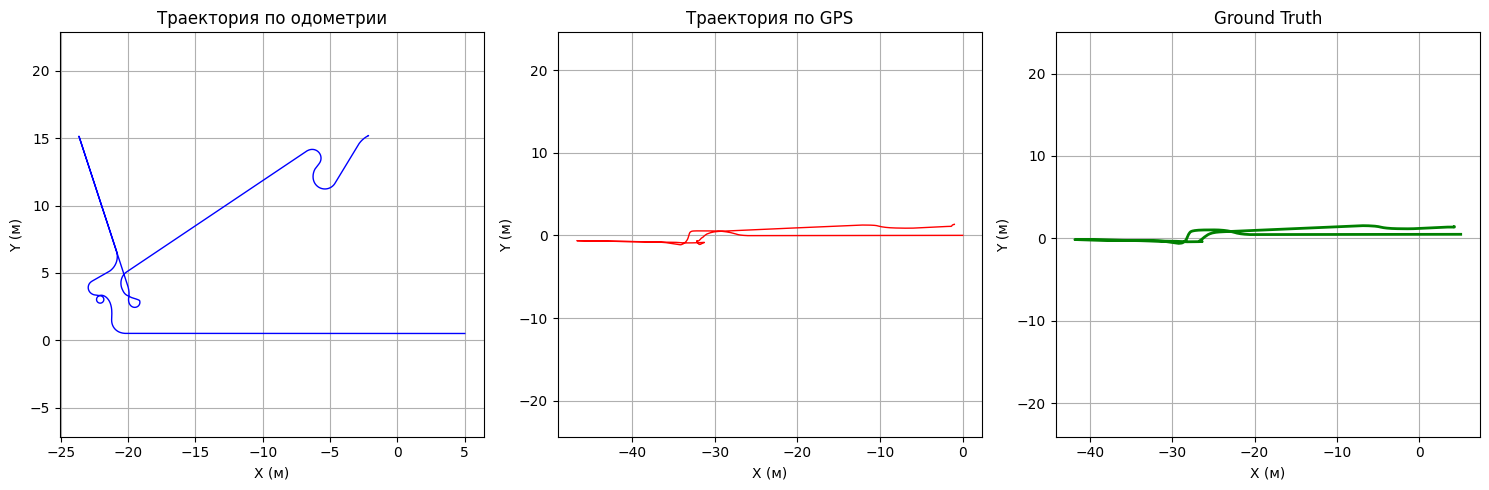

In [91]:
# 2. Построение графиков траекторий
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def latlon_to_xy(lat, lon):
    lat0, lon0 = lat[0], lon[0]
    R = 6371000
    
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    lat0_rad = np.radians(lat0)
    
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * np.cos(lat0_rad)
    
    x = (lon - lon0) * m_per_deg_lon
    y = (lat - lat0) * m_per_deg_lat
    
    return x, y

lat = gps_fix['latitude'].values
lon = gps_fix['longitude'].values
gps_x, gps_y = latlon_to_xy(lat, lon)

odom_x_raw = odom['pose_pose_position_x'].values
odom_y_raw = odom['pose_pose_position_y'].values

gt_x = ground_truth['pose_pose_position_x'].values
gt_y = ground_truth['pose_pose_position_y'].values

odom_x_rotated = -odom_x_raw
odom_y_rotated = -odom_y_raw

offset_x = gt_x[0] - odom_x_rotated[0]
offset_y = gt_y[0] - odom_y_rotated[0]

odom_x = odom_x_rotated + offset_x
odom_y = odom_y_rotated + offset_y

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(odom_x, odom_y, 'b-', linewidth=1)
plt.title('Траектория по одометрии')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.plot(gps_x, gps_y, 'r-', linewidth=1)
plt.title('Траектория по GPS')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.plot(gt_x, gt_y, 'g-', linewidth=2)
plt.title('Ground Truth')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

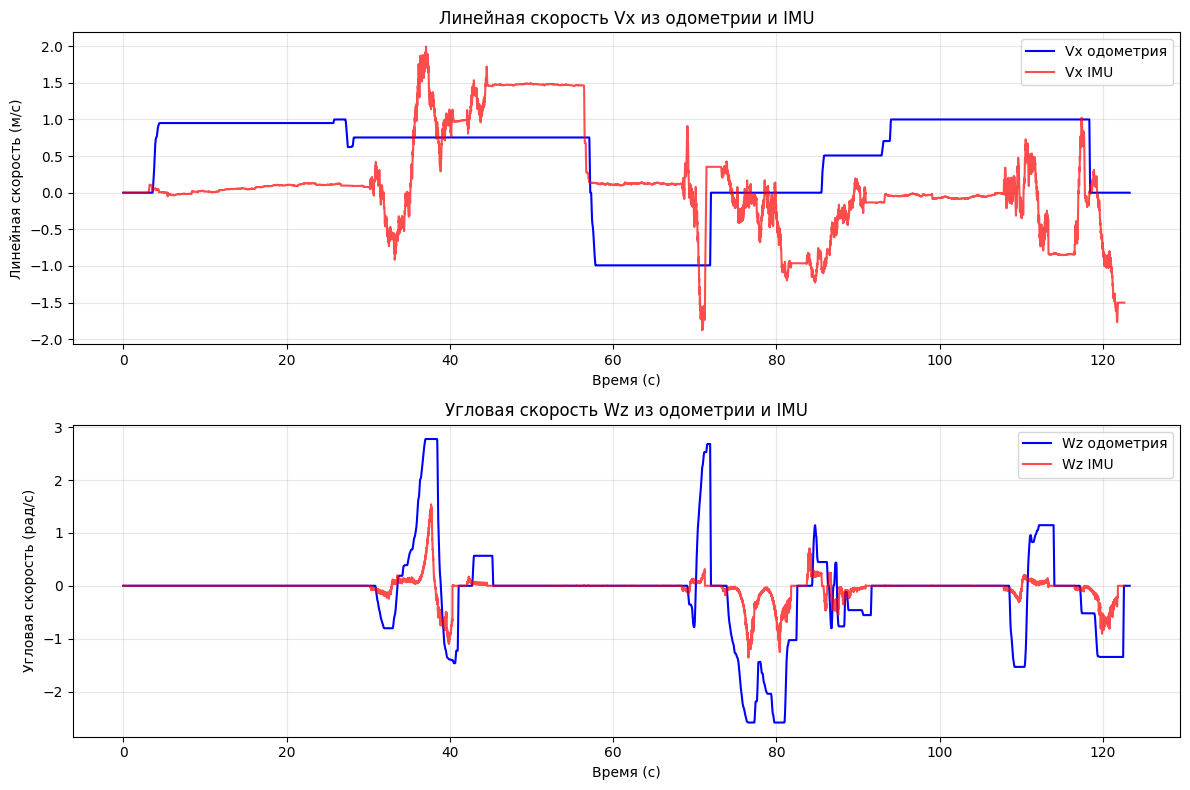

In [93]:
# 3. Построение графиков угловой и линейной скорости из одометрии и IMU
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate

def extract_time_from_odom(odom_df):
    return odom_df['header_stamp_secs'] + odom_df['header_stamp_nsecs'] * 1e-9

def extract_time_from_imu(imu_df):
    return imu_df['header_stamp_secs'] + imu_df['header_stamp_nsecs'] * 1e-9

odom_time = extract_time_from_odom(odom)
odom_time = odom_time - odom_time.iloc[0]

imu_time = extract_time_from_imu(imu)
imu_time = imu_time - imu_time.iloc[0]

odom_linear_vel_x = odom['twist_twist_linear_x'].values
odom_angular_vel_z = odom['twist_twist_angular_z'].values

imu_linear_acc_x = imu['linear_acceleration_x'].values
imu_angular_vel_z = imu['angular_velocity_z'].values

# Интегрируем ускорение IMU для получения скорости
imu_accel_centered = imu_linear_acc_x - np.mean(imu_linear_acc_x[:10])  
imu_velocity_from_accel = integrate.cumulative_trapezoid(imu_accel_centered, imu_time, initial=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(odom_time, odom_linear_vel_x, 'b-', linewidth=1.5, label='Vx одометрия')
axes[0].plot(imu_time, imu_velocity_from_accel, 'r-', linewidth=1.5, alpha=0.7, label='Vx IMU')
axes[0].set_xlabel('Время (с)')
axes[0].set_ylabel('Линейная скорость (м/с)')
axes[0].set_title('Линейная скорость Vx из одометрии и IMU')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(odom_time, odom_angular_vel_z, 'b-', linewidth=1.5, label='Wz одометрия')
axes[1].plot(imu_time, imu_angular_vel_z, 'r-', linewidth=1.5, alpha=0.7, label='Wz IMU')
axes[1].set_xlabel('Время (с)')
axes[1].set_ylabel('Угловая скорость (рад/с)')
axes[1].set_title('Угловая скорость Wz из одометрии и IMU')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()



ОДОМЕТРИЯ:
  - Количество измерений: 6164
  - Средний интервал: 20.000 мс
  - Частота: 50.0 Гц
  - NaN значения: 0
  - Выбросы в интервалах: 0 из 6163 (0.00%)

IMU:
  - Количество измерений: 23692
  - Средний интервал: 5.175 мс
  - Частота: 193.2 Гц
  - NaN значения: 0
  - Выбросы в интервалах: 800 из 23691 (3.38%)

GPS:
  - Количество измерений: 1227
  - Средний интервал: 173.773 мс
  - Частота: 5.8 Гц
  - NaN значения: 1227
  - Выбросы в интервалах: 48 из 1226 (3.92%)

GROUND TRUTH:
  - Количество измерений: 6232
  - Средний интервал: 20.000 мс
  - Частота: 50.0 Гц
  - NaN значения: 0
  - Выбросы в интервалах: 0 из 6231 (0.00%)


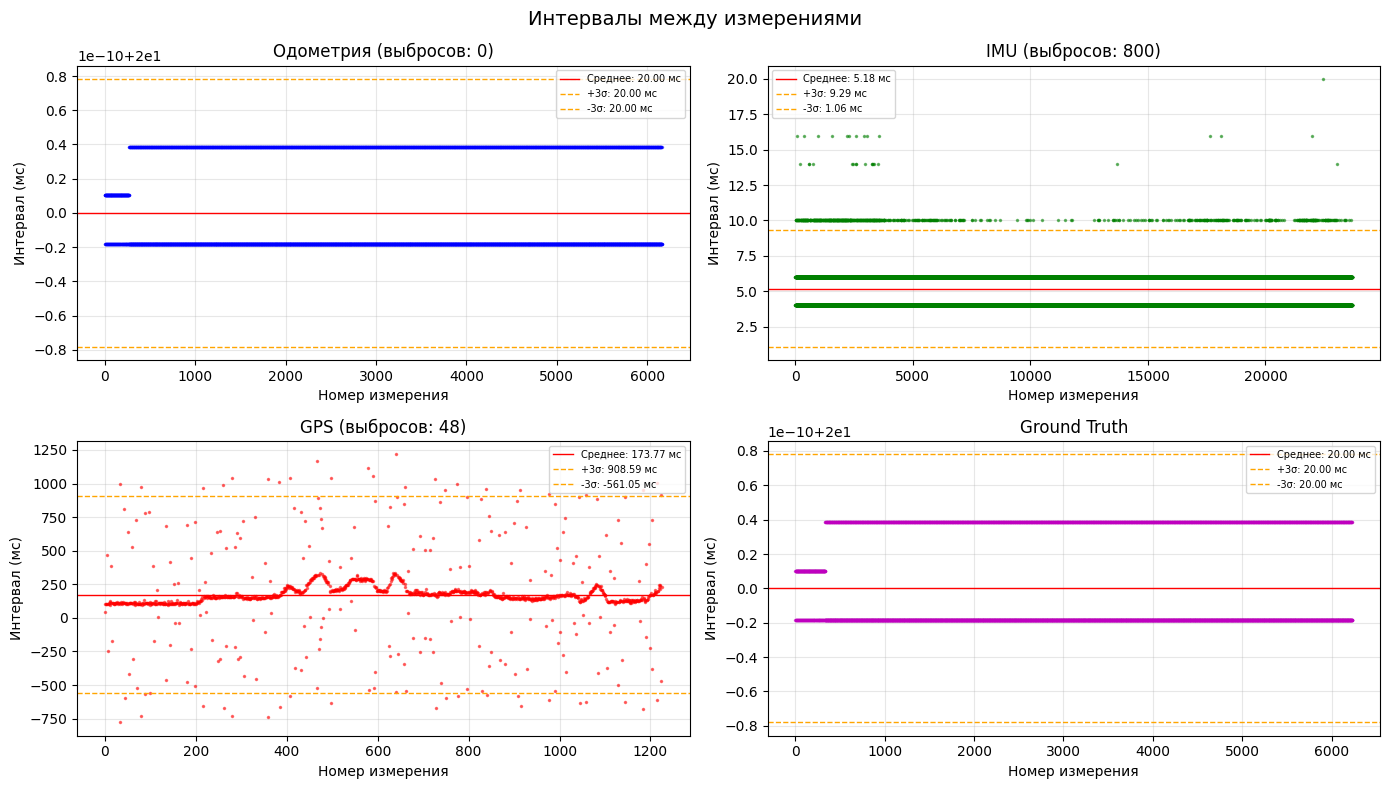

In [95]:
# Анализ данных для отчета
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_frequency(timestamps, name):
    if len(timestamps) < 2:
        return 0, 0, []
    
    dt = np.diff(timestamps)
    mean_dt = np.mean(dt)
    freq = 1.0 / mean_dt if mean_dt > 0 else 0
    
    print(f"\n{name}:")
    print(f"  Средний интервал между измерениями: {mean_dt*1000:.3f} мс")
    print(f"  Средняя частота обновления: {freq:.1f} Гц")
    return freq, mean_dt, dt

def check_nan_and_outliers(df, name, timestamps, dt_values):
    print(f"\n{name}:")
    
    nan_count = df.isna().sum().sum()
    print(f"  Количество NaN значений: {nan_count}")
    
    if name == "IMU":
        imu_nans = {
            'orientation_x': df['orientation_x'].isna().sum(),
            'orientation_y': df['orientation_y'].isna().sum(),
            'orientation_z': df['orientation_z'].isna().sum(),
            'orientation_w': df['orientation_w'].isna().sum(),
            'angular_velocity_z': df['angular_velocity_z'].isna().sum()
        }
        for col, nans in imu_nans.items():
            if nans > 0:
                print(f"    - {col}: {nans} NaN")
    
    elif name == "GPS":
        gps_nans = {
            'latitude': df['latitude'].isna().sum(),
            'longitude': df['longitude'].isna().sum()
        }
        for col, nans in gps_nans.items():
            if nans > 0:
                print(f"    - {col}: {nans} NaN")
    
    elif name == "Ground Truth":
        gt_nans = {
            'pose_pose_position_x': df['pose_pose_position_x'].isna().sum(),
            'pose_pose_position_y': df['pose_pose_position_y'].isna().sum()
        }
        for col, nans in gt_nans.items():
            if nans > 0:
                print(f"    - {col}: {nans} NaN")
    
    if 'header_stamp_secs' in df.columns:
        time_pairs = list(zip(df['header_stamp_secs'], df['header_stamp_nsecs']))
        duplicates = len(time_pairs) - len(set(time_pairs))
        print(f"  Дубликаты по времени: {duplicates}")
    elif 'time' in df.columns:
        duplicates = df['time'].duplicated().sum()
        print(f"  Дубликаты по времени: {duplicates}")
    
    if len(dt_values) > 0:
        mean_dt = np.mean(dt_values)
        std_dt = np.std(dt_values)
        outliers = dt_values[np.abs(dt_values - mean_dt) > 3*std_dt]
        print(f"  Выбросы в интервалах (>3σ): {len(outliers)} из {len(dt_values)} ({len(outliers)/len(dt_values)*100:.2f}%)")
        
        if len(outliers) > 0:
            outlier_values = outliers * 1000  # в мс
            outlier_str = ", ".join([f"{x:.1f}" for x in outlier_values[:5]])
            print(f"    - Значения выбросов (мс): [{outlier_str}]{'...' if len(outliers) > 5 else ''}")
            print(f"    - Минимальный выброс: {np.min(outlier_values):.1f} мс")
            print(f"    - Максимальный выброс: {np.max(outlier_values):.1f} мс")
        
        return nan_count, len(outliers)
    
    return nan_count, 0


print(f"\nОДОМЕТРИЯ:")
print(f"  - Количество измерений: {len(odom)}")
print(f"  - Средний интервал: {mean_dt_odom*1000:.3f} мс")
print(f"  - Частота: {freq_odom:.1f} Гц")
print(f"  - NaN значения: {nan_odom}")
print(f"  - Выбросы в интервалах: {out_odom} из {len(dt_odom)} ({out_odom/len(dt_odom)*100:.2f}%)")

print(f"\nIMU:")
print(f"  - Количество измерений: {len(imu)}")
print(f"  - Средний интервал: {mean_dt_imu*1000:.3f} мс")
print(f"  - Частота: {freq_imu:.1f} Гц")
print(f"  - NaN значения: {nan_imu}")
print(f"  - Выбросы в интервалах: {out_imu} из {len(dt_imu)} ({out_imu/len(dt_imu)*100:.2f}%)")

print(f"\nGPS:")
print(f"  - Количество измерений: {len(gps_fix)}")
print(f"  - Средний интервал: {mean_dt_gps*1000:.3f} мс")
print(f"  - Частота: {freq_gps:.1f} Гц")
print(f"  - NaN значения: {nan_gps}")
print(f"  - Выбросы в интервалах: {out_gps} из {len(dt_gps)} ({out_gps/len(dt_gps)*100:.2f}%)")

print(f"\nGROUND TRUTH:")
print(f"  - Количество измерений: {len(ground_truth)}")
print(f"  - Средний интервал: {mean_dt_gt*1000:.3f} мс")
print(f"  - Частота: {freq_gt:.1f} Гц")
print(f"  - NaN значения: {nan_gt}")
print(f"  - Выбросы в интервалах: {out_gt} из {len(dt_gt)} ({out_gt/len(dt_gt)*100:.2f}%)")


fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Одометрия
axes[0, 0].plot(dt_odom*1000, 'b.', markersize=3, alpha=0.5)
axes[0, 0].axhline(y=mean_dt_odom*1000, color='r', linestyle='-', linewidth=1, 
                   label=f'Среднее: {mean_dt_odom*1000:.2f} мс')
std_odom = np.std(dt_odom)*1000
if std_odom > 0:
    axes[0, 0].axhline(y=(mean_dt_odom*1000 + 3*std_odom), color='orange', linestyle='--', linewidth=1, 
                       label=f'+3σ: {mean_dt_odom*1000 + 3*std_odom:.2f} мс')
    axes[0, 0].axhline(y=(mean_dt_odom*1000 - 3*std_odom), color='orange', linestyle='--', linewidth=1,
                       label=f'-3σ: {mean_dt_odom*1000 - 3*std_odom:.2f} мс')
axes[0, 0].set_xlabel('Номер измерения')
axes[0, 0].set_ylabel('Интервал (мс)')
axes[0, 0].set_title(f'Одометрия (выбросов: {out_odom})')
axes[0, 0].legend(fontsize=7)
axes[0, 0].grid(True, alpha=0.3)

# IMU
axes[0, 1].plot(dt_imu*1000, 'g.', markersize=3, alpha=0.5)
axes[0, 1].axhline(y=mean_dt_imu*1000, color='r', linestyle='-', linewidth=1, 
                   label=f'Среднее: {mean_dt_imu*1000:.2f} мс')
std_imu = np.std(dt_imu)*1000
if std_imu > 0:
    axes[0, 1].axhline(y=(mean_dt_imu*1000 + 3*std_imu), color='orange', linestyle='--', linewidth=1,
                       label=f'+3σ: {mean_dt_imu*1000 + 3*std_imu:.2f} мс')
    axes[0, 1].axhline(y=(mean_dt_imu*1000 - 3*std_imu), color='orange', linestyle='--', linewidth=1,
                       label=f'-3σ: {mean_dt_imu*1000 - 3*std_imu:.2f} мс')
axes[0, 1].set_xlabel('Номер измерения')
axes[0, 1].set_ylabel('Интервал (мс)')
axes[0, 1].set_title(f'IMU (выбросов: {out_imu})')
axes[0, 1].legend(fontsize=7)
axes[0, 1].grid(True, alpha=0.3)

# GPS
axes[1, 0].plot(dt_gps*1000, 'r.', markersize=3, alpha=0.5)
axes[1, 0].axhline(y=mean_dt_gps*1000, color='r', linestyle='-', linewidth=1, 
                   label=f'Среднее: {mean_dt_gps*1000:.2f} мс')
std_gps = np.std(dt_gps)*1000
if std_gps > 0:
    axes[1, 0].axhline(y=(mean_dt_gps*1000 + 3*std_gps), color='orange', linestyle='--', linewidth=1,
                       label=f'+3σ: {mean_dt_gps*1000 + 3*std_gps:.2f} мс')
    axes[1, 0].axhline(y=(mean_dt_gps*1000 - 3*std_gps), color='orange', linestyle='--', linewidth=1,
                       label=f'-3σ: {mean_dt_gps*1000 - 3*std_gps:.2f} мс')
axes[1, 0].set_xlabel('Номер измерения')
axes[1, 0].set_ylabel('Интервал (мс)')
axes[1, 0].set_title(f'GPS (выбросов: {out_gps})')
axes[1, 0].legend(fontsize=7)
axes[1, 0].grid(True, alpha=0.3)

# Ground Truth
axes[1, 1].plot(dt_gt*1000, 'm.', markersize=3, alpha=0.5)
axes[1, 1].axhline(y=mean_dt_gt*1000, color='r', linestyle='-', linewidth=1, 
                   label=f'Среднее: {mean_dt_gt*1000:.2f} мс')
std_gt = np.std(dt_gt)*1000
if std_gt > 0:
    axes[1, 1].axhline(y=(mean_dt_gt*1000 + 3*std_gt), color='orange', linestyle='--', linewidth=1,
                       label=f'+3σ: {mean_dt_gt*1000 + 3*std_gt:.2f} мс')
    axes[1, 1].axhline(y=(mean_dt_gt*1000 - 3*std_gt), color='orange', linestyle='--', linewidth=1,
                       label=f'-3σ: {mean_dt_gt*1000 - 3*std_gt:.2f} мс')
axes[1, 1].set_xlabel('Номер измерения')
axes[1, 1].set_ylabel('Интервал (мс)')
axes[1, 1].set_title(f'Ground Truth')
axes[1, 1].legend(fontsize=7)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Интервалы между измерениями', fontsize=14)
plt.tight_layout()
plt.show()

В результате выполнения первого задания были построены отдельные графики траекторий для:
- одометрии
- траектории только по gps
- траектории истинной по ground_truth
Также построены графики угловой скорости wx и линейной скорости vx во времени из одометрии и IMU.
В блоке анализа данных для отчета описаны частоты обновления каждого датчика. ВИдно, что для gps получено меньше всего значений, поскольку измерение gps обычно долгое и для получения информации о местоположении необходимо получить информацию с нескольких источников и синхронизировать ее.
Одометрия хорошо дрейфует со временем, особенно на поворотах и смене направления траектории. На линейных участках дрейфа не наблюдается.

РЕЗУЛЬТАТЫ ФИЛЬТРАЦИИ

Метод                RMSE (м)        Средняя ошибка      
-------------------------------------------------------
Одометрия            10.779          8.683               
EKF                  10.889          8.787               

Улучшение точности: -1.0%


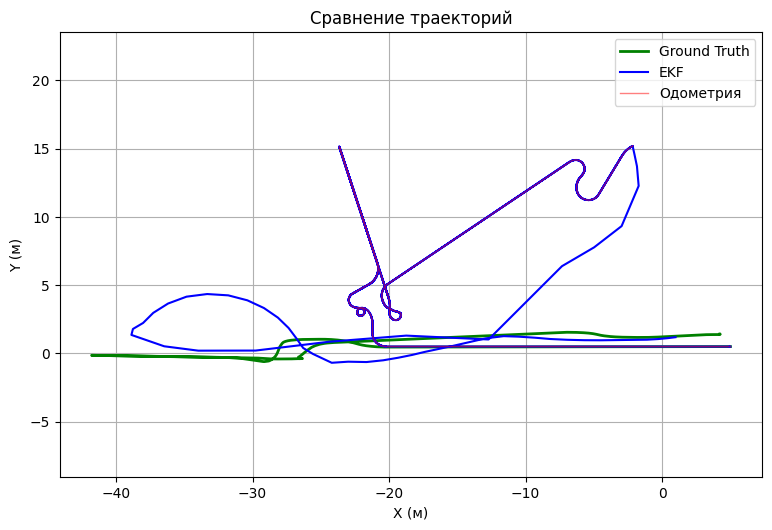

In [ ]:
# Задание 2:Расширенный фильтр Калмана EKF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import math

def quaternion_to_yaw(x, y, z, w):
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    return yaw

def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def latlon_to_xy(lat, lon, lat0, lon0):
    R = 6371000
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    lat0_rad = np.radians(lat0)
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * np.cos(lat0_rad)
    x = (lon - lon0) * m_per_deg_lon
    y = (lat - lat0) * m_per_deg_lat
    return x, y

class ExtendedKalmanFilter:
    def __init__(self):
        self.dim_x = 5
        self.x = np.zeros(self.dim_x)
        self.P = np.eye(self.dim_x) * 1000
        self.P[2, 2] = np.pi**2
        self.Q = np.diag([0.01, 0.01, 0.001, 0.1, 0.01])
        
    def predict(self, dt):
        x, y, yaw, v, w = self.x
        self.x[0] = x + v * np.cos(yaw) * dt
        self.x[1] = y + v * np.sin(yaw) * dt
        self.x[2] = normalize_angle(yaw + w * dt)
        
        F = np.eye(self.dim_x)
        F[0, 2] = -v * np.sin(yaw) * dt
        F[0, 3] = np.cos(yaw) * dt
        F[1, 2] = v * np.cos(yaw) * dt
        F[1, 3] = np.sin(yaw) * dt
        F[2, 4] = dt
        
        self.P = F @ self.P @ F.T + self.Q
        
    def update(self, z, H, R):
        y = z - H @ self.x
        angle_indices = np.where(H[:, 2] != 0)[0]
        for idx in angle_indices:
            y[idx] = normalize_angle(y[idx])
        
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        self.x = self.x + K @ y
        self.x[2] = normalize_angle(self.x[2])
        
        I = np.eye(self.dim_x)
        self.P = (I - K @ H) @ self.P @ (I - K @ H).T + K @ R @ K.T
        
    def update_odometry(self, odom_data):
        z = np.array([odom_data['x'], odom_data['y'], odom_data['yaw'], 
                      odom_data['v'], odom_data['w']])
        H = np.eye(self.dim_x)
        R = np.diag([0.001, 0.001, 0.001, 0.001, 0.001])
        self.update(z, H, R)
        
    def update_gps(self, gps_data, lat0, lon0):
        x_gps, y_gps = latlon_to_xy(gps_data['lat'], gps_data['lon'], lat0, lon0)
        z = np.array([x_gps, y_gps])
        H = np.zeros((2, self.dim_x))
        H[0, 0] = 1
        H[1, 1] = 1
        R = np.diag([100.0, 100.0])
        self.update(z, H, R)
        
    def update_imu_yaw(self, imu_data):
        yaw_imu = quaternion_to_yaw(
            imu_data['orientation_x'], imu_data['orientation_y'],
            imu_data['orientation_z'], imu_data['orientation_w'])
        z = np.array([yaw_imu])
        H = np.zeros((1, self.dim_x))
        H[0, 2] = 1
        R = np.array([[0.001]])
        self.update(z, H, R)
        
    def update_imu_angular_velocity(self, imu_data):
        w_imu = imu_data['angular_velocity_z']
        z = np.array([w_imu])
        H = np.zeros((1, self.dim_x))
        H[0, 4] = 1
        R = np.array([[1e-6]])
        self.update(z, H, R)


odom_time = odom['header_stamp_secs'] + odom['header_stamp_nsecs'] * 1e-9
odom_time = odom_time - odom_time.iloc[0]

imu_time = imu['header_stamp_secs'] + imu['header_stamp_nsecs'] * 1e-9
imu_time = imu_time - imu_time.iloc[0]

gps_time = pd.to_datetime(gps_fix['time']).astype('int64') * 1e-9
gps_time = gps_time - gps_time.iloc[0]

gt_time = ground_truth['header_stamp_secs'] + ground_truth['header_stamp_nsecs'] * 1e-9
gt_time = gt_time - gt_time.iloc[0]

lat0, lon0 = gps_fix['latitude'].iloc[0], gps_fix['longitude'].iloc[0]

odom_x_raw = odom['pose_pose_position_x'].values
odom_y_raw = odom['pose_pose_position_y'].values

odom_x_rotated = -odom_x_raw
odom_y_rotated = -odom_y_raw

gt_x = ground_truth['pose_pose_position_x'].values
gt_y = ground_truth['pose_pose_position_y'].values

offset_x = gt_x[0] - odom_x_rotated[0]
offset_y = gt_y[0] - odom_y_rotated[0]

odom_x = odom_x_rotated + offset_x
odom_y = odom_y_rotated + offset_y

events = []

for i in range(len(odom)):
    events.append({
        'time': odom_time.iloc[i],
        'type': 'odom',
        'data': {
            'x': odom_x[i],
            'y': odom_y[i],
            'yaw': quaternion_to_yaw(
                odom.iloc[i]['pose_pose_orientation_x'],
                odom.iloc[i]['pose_pose_orientation_y'],
                odom.iloc[i]['pose_pose_orientation_z'],
                odom.iloc[i]['pose_pose_orientation_w']),
            'v': odom.iloc[i]['twist_twist_linear_x'],
            'w': odom.iloc[i]['twist_twist_angular_z']
        }
    })

for i in range(len(imu)):
    events.append({
        'time': imu_time.iloc[i],
        'type': 'imu',
        'data': imu.iloc[i]
    })

gps_counter = 0
for i in range(len(gps_fix)):
    if gps_counter % 10 == 0:
        events.append({
            'time': gps_time[i],
            'type': 'gps',
            'data': {
                'lat': gps_fix.iloc[i]['latitude'],
                'lon': gps_fix.iloc[i]['longitude']
            }
        })
    gps_counter += 1

events.sort(key=lambda x: x['time'])

ekf = ExtendedKalmanFilter()

ekf.x = np.array([
    odom_x[0],
    odom_y[0],
    quaternion_to_yaw(
        odom.iloc[0]['pose_pose_orientation_x'],
        odom.iloc[0]['pose_pose_orientation_y'],
        odom.iloc[0]['pose_pose_orientation_z'],
        odom.iloc[0]['pose_pose_orientation_w']),
    gps_odom.iloc[0]['twist_twist_linear_x'],
    gps_odom.iloc[0]['twist_twist_angular_z']
])

times = []
states = []
last_time = 0

for i, event in enumerate(events):
    current_time = event['time']
    dt = current_time - last_time
    
    if dt > 0:
        ekf.predict(dt)
    
    if event['type'] == 'odom':
        ekf.update_odometry(event['data'])
    elif event['type'] == 'imu':
        ekf.update_imu_yaw(event['data'])
        ekf.update_imu_angular_velocity(event['data'])
    elif event['type'] == 'gps':
        ekf.update_gps(event['data'], lat0, lon0)
    
    times.append(current_time)
    states.append(ekf.x.copy())
    last_time = current_time
    

states = np.array(states)
times = np.array(times)

gt_x_interp = np.interp(times, gt_time, gt_x)
gt_y_interp = np.interp(times, gt_time, gt_y)

ekf_errors = np.sqrt((states[:, 0] - gt_x_interp)**2 + (states[:, 1] - gt_y_interp)**2)
odom_errors = np.sqrt((odom_x - gt_x[:len(odom_x)])**2 + (odom_y - gt_y[:len(odom_y)])**2)

print("РЕЗУЛЬТАТЫ ФИЛЬТРАЦИИ")
print(f"\n{'Метод':<20} {'RMSE (м)':<15} {'Средняя ошибка':<20}")
print("-"*55)
print(f"{'Одометрия':<20} {np.sqrt(np.mean(odom_errors**2)):<15.3f} {np.mean(odom_errors):<20.3f}")
print(f"{'EKF':<20} {np.sqrt(np.mean(ekf_errors**2)):<15.3f} {np.mean(ekf_errors):<20.3f}")

improvement = ((np.sqrt(np.mean(odom_errors**2)) - np.sqrt(np.mean(ekf_errors**2))) / 
               np.sqrt(np.mean(odom_errors**2)) * 100)
print(f"\nУлучшение точности: {improvement:.1f}%")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(gt_x, gt_y, 'g-', linewidth=2, label='Ground Truth')
plt.plot(states[:, 0], states[:, 1], 'b-', linewidth=1.5, label='EKF')
plt.plot(odom_x, odom_y, 'r-', linewidth=1, alpha=0.5, label='Одометрия')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.title('Сравнение траекторий')
plt.legend()
plt.grid(True)
plt.axis('equal')


plt.tight_layout()
plt.show()


В результате применения фильтра Калмана траектория приобрела адекватный вид. ВИдно, как на прямолинейных участках траектория разгладилась.

ЗАДАНИЕ 1: ТРАЕКТОРИИ


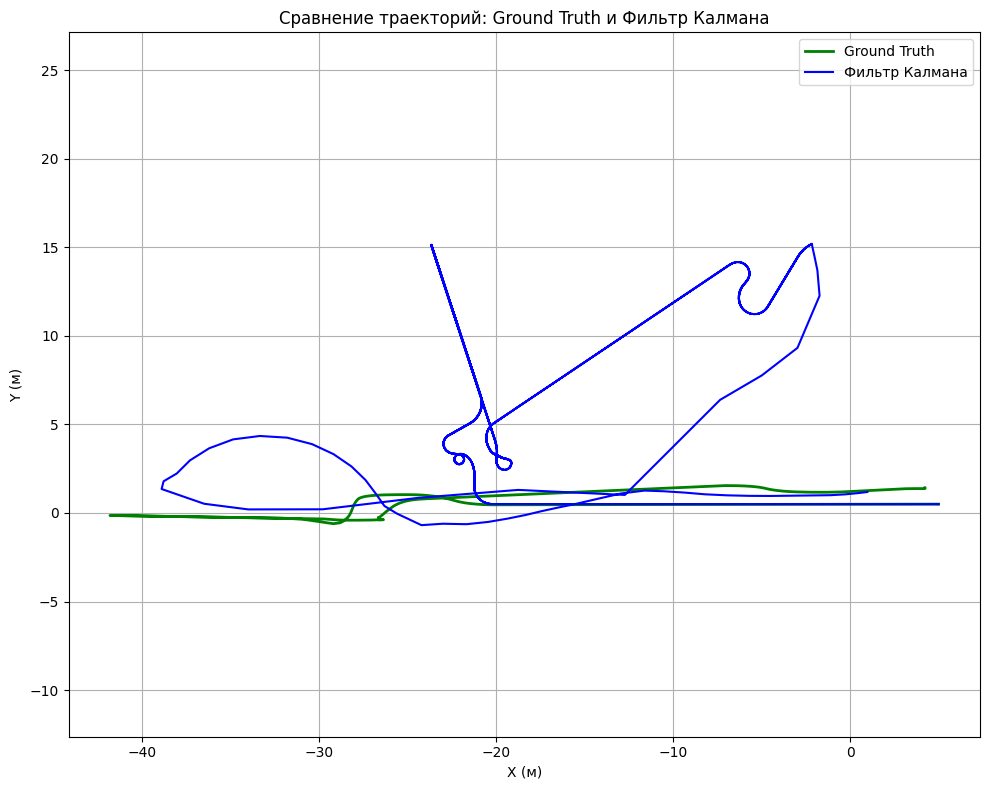

ЗАДАНИЕ 2: МЕТРИКИ ОШИБКИ

RMSE X: 7.932 м
RMSE Y: 7.460 м
RMSE θ: 2.873 рад
ЗАДАНИЕ 3: ГРАФИКИ ОШИБОК ВО ВРЕМЕНИ


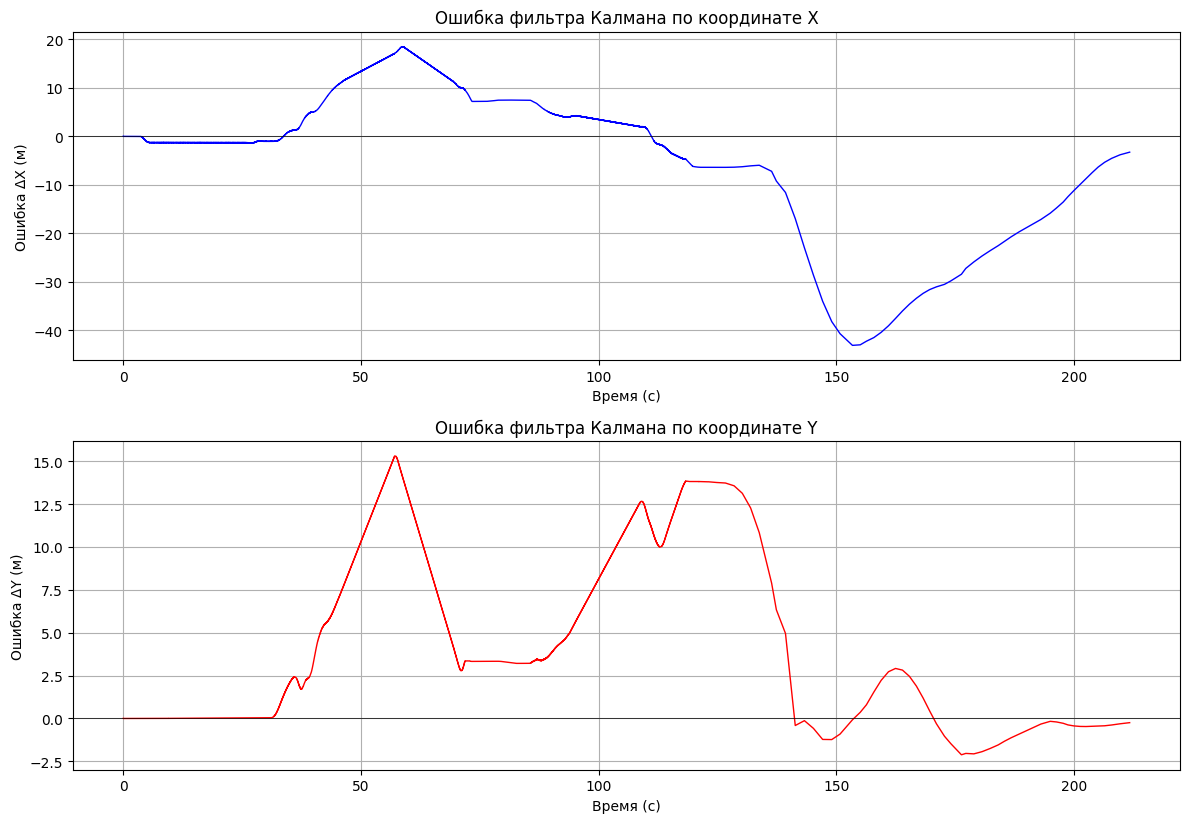

ЗАДАНИЕ 4: ТАБЛИЦА СРАВНЕНИЯ


----------------------------------------------------------------------
Метод                RMSE X (м)      RMSE Y (м)      RMSE θ (рад)   
----------------------------------------------------------------------
Только одометрия     7.782           7.458           2.370          
Только GPS           26.668          0.888           -              
Фильтр Калмана       7.932           7.460           2.873          
----------------------------------------------------------------------

Улучшение относительно одометрии по X: -1.9%
Улучшение относительно одометрии по Y: -0.0%
Улучшение относительно одометрии по θ: -21.2%
ЗАДАНИЕ 5: АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ


--------------------------------------------------------------------------------
Конфигурация                   RMSE X (м)      RMSE Y (м)      RMSE θ (рад)   
--------------------------------------------------------------------------------
Базовый EKF                    7.932           7.460           2.

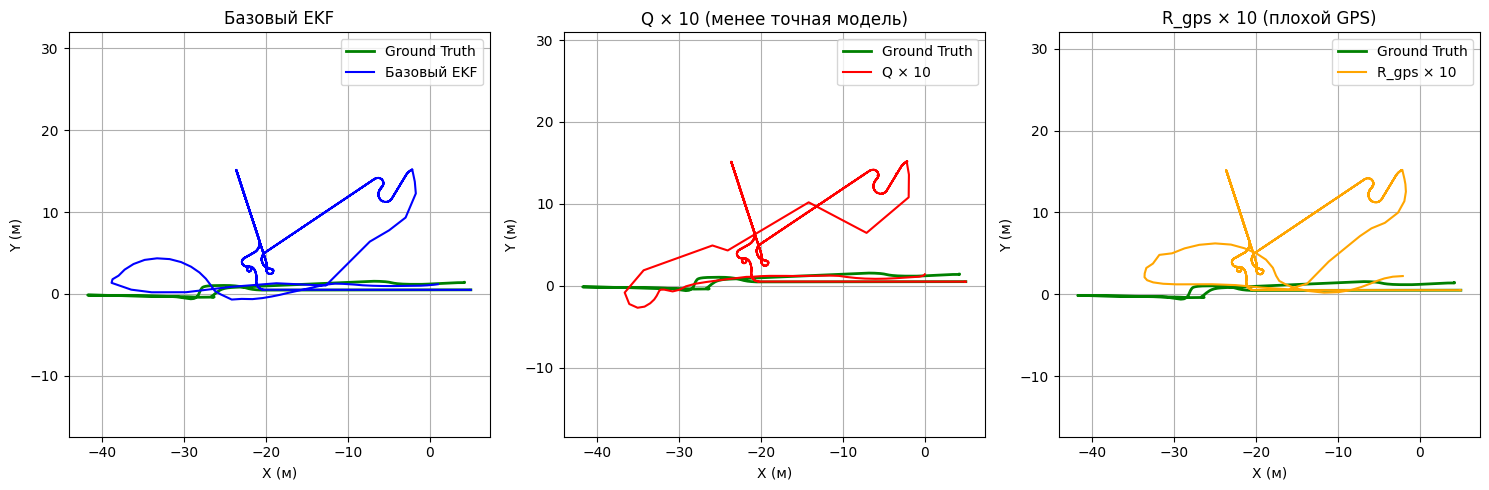

In [ ]:
# Задание 3: Анализ результатов
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import math

def quaternion_to_yaw(x, y, z, w):
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    return yaw

def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def latlon_to_xy(lat, lon, lat0, lon0):
    R = 6371000
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    lat0_rad = np.radians(lat0)
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * np.cos(lat0_rad)
    x = (lon - lon0) * m_per_deg_lon
    y = (lat - lat0) * m_per_deg_lat
    return x, y

class ExtendedKalmanFilter:
    def __init__(self, Q_scale=1.0, R_gps_scale=1.0):
        self.dim_x = 5
        self.x = np.zeros(self.dim_x)
        self.P = np.eye(self.dim_x) * 1000
        self.P[2, 2] = np.pi**2
        self.Q = np.diag([0.01, 0.01, 0.001, 0.1, 0.01]) * Q_scale
        self.R_gps_scale = R_gps_scale
        
    def predict(self, dt):
        x, y, yaw, v, w = self.x
        self.x[0] = x + v * np.cos(yaw) * dt
        self.x[1] = y + v * np.sin(yaw) * dt
        self.x[2] = normalize_angle(yaw + w * dt)
        
        F = np.eye(self.dim_x)
        F[0, 2] = -v * np.sin(yaw) * dt
        F[0, 3] = np.cos(yaw) * dt
        F[1, 2] = v * np.cos(yaw) * dt
        F[1, 3] = np.sin(yaw) * dt
        F[2, 4] = dt
        
        self.P = F @ self.P @ F.T + self.Q
        
    def update(self, z, H, R):
        y = z - H @ self.x
        angle_indices = np.where(H[:, 2] != 0)[0]
        for idx in angle_indices:
            y[idx] = normalize_angle(y[idx])
        
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        self.x = self.x + K @ y
        self.x[2] = normalize_angle(self.x[2])
        
        I = np.eye(self.dim_x)
        self.P = (I - K @ H) @ self.P @ (I - K @ H).T + K @ R @ K.T
        
    def update_odometry(self, odom_data):
        z = np.array([odom_data['x'], odom_data['y'], odom_data['yaw'], 
                      odom_data['v'], odom_data['w']])
        H = np.eye(self.dim_x)
        R = np.diag([0.001, 0.001, 0.001, 0.001, 0.001])
        self.update(z, H, R)
        
    def update_gps(self, gps_data, lat0, lon0):
        x_gps, y_gps = latlon_to_xy(gps_data['lat'], gps_data['lon'], lat0, lon0)
        z = np.array([x_gps, y_gps])
        H = np.zeros((2, self.dim_x))
        H[0, 0] = 1
        H[1, 1] = 1
        R = np.diag([100.0, 100.0]) * self.R_gps_scale
        self.update(z, H, R)
        
    def update_imu_yaw(self, imu_data):
        yaw_imu = quaternion_to_yaw(
            imu_data['orientation_x'], imu_data['orientation_y'],
            imu_data['orientation_z'], imu_data['orientation_w'])
        z = np.array([yaw_imu])
        H = np.zeros((1, self.dim_x))
        H[0, 2] = 1
        R = np.array([[0.001]])
        self.update(z, H, R)
        
    def update_imu_angular_velocity(self, imu_data):
        w_imu = imu_data['angular_velocity_z']
        z = np.array([w_imu])
        H = np.zeros((1, self.dim_x))
        H[0, 4] = 1
        R = np.array([[1e-6]])
        self.update(z, H, R)

def run_ekf(Q_scale=1.0, R_gps_scale=1.0):
    ekf = ExtendedKalmanFilter(Q_scale, R_gps_scale)
    
    ekf.x = np.array([
        odom_x[0],
        odom_y[0],
        quaternion_to_yaw(
            odom.iloc[0]['pose_pose_orientation_x'],
            odom.iloc[0]['pose_pose_orientation_y'],
            odom.iloc[0]['pose_pose_orientation_z'],
            odom.iloc[0]['pose_pose_orientation_w']),
        odom.iloc[0]['twist_twist_linear_x'],
        odom.iloc[0]['twist_twist_angular_z']
    ])
    
    times = []
    states = []
    last_time = 0
    
    for i, event in enumerate(events):
        current_time = event['time']
        dt = current_time - last_time
        
        if dt > 0:
            ekf.predict(dt)
        
        if event['type'] == 'odom':
            ekf.update_odometry(event['data'])
        elif event['type'] == 'imu':
            ekf.update_imu_yaw(event['data'])
            ekf.update_imu_angular_velocity(event['data'])
        elif event['type'] == 'gps':
            ekf.update_gps(event['data'], lat0, lon0)
        
        times.append(current_time)
        states.append(ekf.x.copy())
        last_time = current_time
        
    return np.array(times), np.array(states)

odom_time = odom['header_stamp_secs'] + odom['header_stamp_nsecs'] * 1e-9
odom_time = odom_time - odom_time.iloc[0]

imu_time = imu['header_stamp_secs'] + imu['header_stamp_nsecs'] * 1e-9
imu_time = imu_time - imu_time.iloc[0]

gps_time = pd.to_datetime(gps_fix['time']).astype('int64') * 1e-9
gps_time = gps_time - gps_time.iloc[0]

gt_time = ground_truth['header_stamp_secs'] + ground_truth['header_stamp_nsecs'] * 1e-9
gt_time = gt_time - gt_time.iloc[0]

lat0, lon0 = gps_fix['latitude'].iloc[0], gps_fix['longitude'].iloc[0]

odom_x_raw = odom['pose_pose_position_x'].values
odom_y_raw = odom['pose_pose_position_y'].values

odom_x_rotated = -odom_x_raw
odom_y_rotated = -odom_y_raw

gt_x = ground_truth['pose_pose_position_x'].values
gt_y = ground_truth['pose_pose_position_y'].values
gt_yaw = np.zeros(len(ground_truth))
for i in range(len(ground_truth)):
    gt_yaw[i] = quaternion_to_yaw(
        ground_truth.iloc[i]['pose_pose_orientation_x'],
        ground_truth.iloc[i]['pose_pose_orientation_y'],
        ground_truth.iloc[i]['pose_pose_orientation_z'],
        ground_truth.iloc[i]['pose_pose_orientation_w'])

offset_x = gt_x[0] - odom_x_rotated[0]
offset_y = gt_y[0] - odom_y_rotated[0]

odom_x = odom_x_rotated + offset_x
odom_y = odom_y_rotated + offset_y

odom_yaw = np.zeros(len(odom))
for i in range(len(odom)):
    odom_yaw[i] = quaternion_to_yaw(
        odom.iloc[i]['pose_pose_orientation_x'],
        odom.iloc[i]['pose_pose_orientation_y'],
        odom.iloc[i]['pose_pose_orientation_z'],
        odom.iloc[i]['pose_pose_orientation_w'])

gps_x_list = []
gps_y_list = []
for i in range(len(gps_fix)):
    x, y = latlon_to_xy(gps_fix.iloc[i]['latitude'], gps_fix.iloc[i]['longitude'], lat0, lon0)
    gps_x_list.append(x)
    gps_y_list.append(y)
gps_x = np.array(gps_x_list)
gps_y = np.array(gps_y_list)

events = []

for i in range(len(odom)):
    events.append({
        'time': odom_time.iloc[i],
        'type': 'odom',
        'data': {
            'x': odom_x[i],
            'y': odom_y[i],
            'yaw': odom_yaw[i],
            'v': odom.iloc[i]['twist_twist_linear_x'],
            'w': odom.iloc[i]['twist_twist_angular_z']
        }
    })

for i in range(len(imu)):
    events.append({
        'time': imu_time.iloc[i],
        'type': 'imu',
        'data': imu.iloc[i]
    })

gps_counter = 0
for i in range(len(gps_fix)):
    if gps_counter % 10 == 0:
        events.append({
            'time': gps_time[i],
            'type': 'gps',
            'data': {
                'lat': gps_fix.iloc[i]['latitude'],
                'lon': gps_fix.iloc[i]['longitude']
            }
        })
    gps_counter += 1

events.sort(key=lambda x: x['time'])

times_ekf, states_ekf = run_ekf(1.0, 1.0)

gt_x_interp = np.interp(times_ekf, gt_time, gt_x)
gt_y_interp = np.interp(times_ekf, gt_time, gt_y)
gt_yaw_interp = np.interp(times_ekf, gt_time, gt_yaw)

error_x_ekf = states_ekf[:, 0] - gt_x_interp
error_y_ekf = states_ekf[:, 1] - gt_y_interp
error_yaw_ekf = normalize_angle(states_ekf[:, 2] - gt_yaw_interp)

error_x_odom = odom_x - gt_x[:len(odom_x)]
error_y_odom = odom_y - gt_y[:len(odom_y)]
error_yaw_odom = normalize_angle(odom_yaw - gt_yaw[:len(odom_yaw)])

error_x_gps = gps_x - gt_x[:len(gps_x)]
error_y_gps = gps_y - gt_y[:len(gps_y)]

rmse_x_ekf = np.sqrt(np.mean(error_x_ekf**2))
rmse_y_ekf = np.sqrt(np.mean(error_y_ekf**2))
rmse_yaw_ekf = np.sqrt(np.mean(error_yaw_ekf**2))

rmse_x_odom = np.sqrt(np.mean(error_x_odom**2))
rmse_y_odom = np.sqrt(np.mean(error_y_odom**2))
rmse_yaw_odom = np.sqrt(np.mean(error_yaw_odom**2))

rmse_x_gps = np.sqrt(np.mean(error_x_gps**2))
rmse_y_gps = np.sqrt(np.mean(error_y_gps**2))

print("ЗАДАНИЕ 1: ТРАЕКТОРИИ")

plt.figure(figsize=(10, 8))
plt.plot(gt_x, gt_y, 'g-', linewidth=2, label='Ground Truth')
plt.plot(states_ekf[:, 0], states_ekf[:, 1], 'b-', linewidth=1.5, label='Фильтр Калмана')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.title('Сравнение траекторий: Ground Truth и Фильтр Калмана')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("ЗАДАНИЕ 2: МЕТРИКИ ОШИБКИ")

print(f"\nRMSE X: {rmse_x_ekf:.3f} м")
print(f"RMSE Y: {rmse_y_ekf:.3f} м")
print(f"RMSE θ: {rmse_yaw_ekf:.3f} рад")

print("ЗАДАНИЕ 3: ГРАФИКИ ОШИБОК ВО ВРЕМЕНИ")

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(times_ekf, error_x_ekf, 'b-', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Время (с)')
plt.ylabel('Ошибка ΔX (м)')
plt.title('Ошибка фильтра Калмана по координате X')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(times_ekf, error_y_ekf, 'r-', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Время (с)')
plt.ylabel('Ошибка ΔY (м)')
plt.title('Ошибка фильтра Калмана по координате Y')
plt.grid(True)

plt.tight_layout()
plt.show()

print("ЗАДАНИЕ 4: ТАБЛИЦА СРАВНЕНИЯ")

print("\n")
print("-" * 70)
print(f"{'Метод':<20} {'RMSE X (м)':<15} {'RMSE Y (м)':<15} {'RMSE θ (рад)':<15}")
print("-" * 70)
print(f"{'Только одометрия':<20} {rmse_x_odom:<15.3f} {rmse_y_odom:<15.3f} {rmse_yaw_odom:<15.3f}")
print(f"{'Только GPS':<20} {rmse_x_gps:<15.3f} {rmse_y_gps:<15.3f} {'-':<15}")
print(f"{'Фильтр Калмана':<20} {rmse_x_ekf:<15.3f} {rmse_y_ekf:<15.3f} {rmse_yaw_ekf:<15.3f}")
print("-" * 70)

improvement_vs_odom_x = (rmse_x_odom - rmse_x_ekf) / rmse_x_odom * 100
improvement_vs_odom_y = (rmse_y_odom - rmse_y_ekf) / rmse_y_odom * 100
improvement_vs_odom_yaw = (rmse_yaw_odom - rmse_yaw_ekf) / rmse_yaw_odom * 100

print(f"\nУлучшение относительно одометрии по X: {improvement_vs_odom_x:.1f}%")
print(f"Улучшение относительно одометрии по Y: {improvement_vs_odom_y:.1f}%")
print(f"Улучшение относительно одометрии по θ: {improvement_vs_odom_yaw:.1f}%")

print("ЗАДАНИЕ 5: АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ")

times_ekf_q10, states_ekf_q10 = run_ekf(10.0, 1.0)
gt_x_interp_q10 = np.interp(times_ekf_q10, gt_time, gt_x)
gt_y_interp_q10 = np.interp(times_ekf_q10, gt_time, gt_y)
gt_yaw_interp_q10 = np.interp(times_ekf_q10, gt_time, gt_yaw)
rmse_x_q10 = np.sqrt(np.mean((states_ekf_q10[:, 0] - gt_x_interp_q10)**2))
rmse_y_q10 = np.sqrt(np.mean((states_ekf_q10[:, 1] - gt_y_interp_q10)**2))
rmse_yaw_q10 = np.sqrt(np.mean(normalize_angle(states_ekf_q10[:, 2] - gt_yaw_interp_q10)**2))

times_ekf_r10, states_ekf_r10 = run_ekf(1.0, 10.0)
gt_x_interp_r10 = np.interp(times_ekf_r10, gt_time, gt_x)
gt_y_interp_r10 = np.interp(times_ekf_r10, gt_time, gt_y)
gt_yaw_interp_r10 = np.interp(times_ekf_r10, gt_time, gt_yaw)
rmse_x_r10 = np.sqrt(np.mean((states_ekf_r10[:, 0] - gt_x_interp_r10)**2))
rmse_y_r10 = np.sqrt(np.mean((states_ekf_r10[:, 1] - gt_y_interp_r10)**2))
rmse_yaw_r10 = np.sqrt(np.mean(normalize_angle(states_ekf_r10[:, 2] - gt_yaw_interp_r10)**2))

print("\n")
print("-" * 80)
print(f"{'Конфигурация':<30} {'RMSE X (м)':<15} {'RMSE Y (м)':<15} {'RMSE θ (рад)':<15}")
print("-" * 80)
print(f"{'Базовый EKF':<30} {rmse_x_ekf:<15.3f} {rmse_y_ekf:<15.3f} {rmse_yaw_ekf:<15.3f}")
print(f"{'Q × 10':<30} {rmse_x_q10:<15.3f} {rmse_y_q10:<15.3f} {rmse_yaw_q10:<15.3f}")
print(f"{'R_gps × 10':<30} {rmse_x_r10:<15.3f} {rmse_y_r10:<15.3f} {rmse_yaw_r10:<15.3f}")
print("-" * 80)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(gt_x, gt_y, 'g-', linewidth=2, label='Ground Truth')
axes[0].plot(states_ekf[:, 0], states_ekf[:, 1], 'b-', linewidth=1.5, label='Базовый EKF')
axes[0].set_xlabel('X (м)')
axes[0].set_ylabel('Y (м)')
axes[0].set_title('Базовый EKF')
axes[0].legend()
axes[0].grid(True)
axes[0].axis('equal')

axes[1].plot(gt_x, gt_y, 'g-', linewidth=2, label='Ground Truth')
axes[1].plot(states_ekf_q10[:, 0], states_ekf_q10[:, 1], 'r-', linewidth=1.5, label='Q × 10')
axes[1].set_xlabel('X (м)')
axes[1].set_ylabel('Y (м)')
axes[1].set_title('Q × 10 (менее точная модель)')
axes[1].legend()
axes[1].grid(True)
axes[1].axis('equal')

axes[2].plot(gt_x, gt_y, 'g-', linewidth=2, label='Ground Truth')
axes[2].plot(states_ekf_r10[:, 0], states_ekf_r10[:, 1], 'orange', linewidth=1.5, label='R_gps × 10')
axes[2].set_xlabel('X (м)')
axes[2].set_ylabel('Y (м)')
axes[2].set_title('R_gps × 10 (плохой GPS)')
axes[2].legend()
axes[2].grid(True)
axes[2].axis('equal')

plt.tight_layout()
plt.show()

Ответы на вопросы:
1. В каких участках траектории фильтр Калмана даёт наибольший выигрыш? (прямолинейное движение, повороты, остановки)
Наибольший выигрыш получается при применении фильтра к прямолинейному движению. На смене траектории движения (углы, повороты) фильтр не дает хороший результат.
2. Как изменится результат, если увеличить R_gps в 10 раз (имитация плохого GPS)? 
В данном конкретном случае результат ухудшается, посколько данные, полученные с одометрии плохо коррелируют с данными по gps и ground_truth
3. Как изменится результат, если увеличить Q в 10 раз (модель менее точная)?
При увеличении Q в 10 раз модель показывает хороший результат, более близкий к результатам данных с gps.